In [538]:
import bagpy
from bagpy import bagreader
from data import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import math

a = bagreader("data/circles.bag")
b = bagreader("data/boston_tour.bag")

gps_msg = a.message_by_topic('/gps')
imu_msg = a.message_by_topic('/imu')

gps_msg1 = b.message_by_topic('/gps')
imu_msg1 = b.message_by_topic('/imu')


gps_c = pd.read_csv(gps_msg)
imu_c= pd.read_csv(imu_msg)

gps_bt = pd.read_csv(gps_msg1)
imu_bt= pd.read_csv(imu_msg1)



[INFO]  Data folder data/circles already exists. Not creating.
[INFO]  Data folder data/boston_tour already exists. Not creating.


In [539]:
imu_c['Time'] = imu_c['Time'] - imu_c['Time'].min()
imu_bt['Time'] = imu_bt['Time'] - imu_bt['Time'].min()
#hard iron
offset_x = (imu_c['MagField.magnetic_field.x'].max() + imu_c['MagField.magnetic_field.x'].min()) / 2
offset_y = (imu_c['MagField.magnetic_field.y'].max() + imu_c['MagField.magnetic_field.y'].min()) / 2
offset_z = (imu_c['MagField.magnetic_field.z'].max() + imu_c['MagField.magnetic_field.z'].min()) / 2

imu_c['corr_x'] = imu_c['MagField.magnetic_field.x'] - offset_x
imu_c['corr_y'] = imu_c['MagField.magnetic_field.y'] - offset_y
imu_c['corr_z'] = imu_c['MagField.magnetic_field.z'] - offset_z

#soft iron
avg_x = (imu_c['corr_x'].max() - imu_c['corr_x'].min()) / 2
avg_y = (imu_c['corr_y'].max() - imu_c['corr_y'].min()) / 2
avg_z = (imu_c['corr_z'].max() - imu_c['corr_z'].min()) / 2

avg_delta = ( avg_x + avg_y + avg_z ) / 3

scale_x = avg_delta / avg_x
scale_y = avg_delta / avg_y
scale_z = avg_delta / avg_z

imu_c['corrected_x'] = (imu_c['corr_x']) * scale_x
imu_c['corrected_y'] = (imu_c['corr_y']) * scale_y
imu_c['corrected_z'] = (imu_c['corr_z']) * scale_z


#boston tour
imu_bt['corr_x'] = imu_bt['MagField.magnetic_field.x'] - offset_x
imu_bt['corr_y'] = imu_bt['MagField.magnetic_field.y'] - offset_y
imu_bt['corr_z'] = imu_bt['MagField.magnetic_field.z'] - offset_z

imu_bt['corrected_x'] = (imu_bt['corr_x']) * scale_x
imu_bt['corrected_y'] = (imu_bt['corr_y']) * scale_y
imu_bt['corrected_z'] = (imu_bt['corr_z']) * scale_z

print(scale_x)


0.7457407407407407


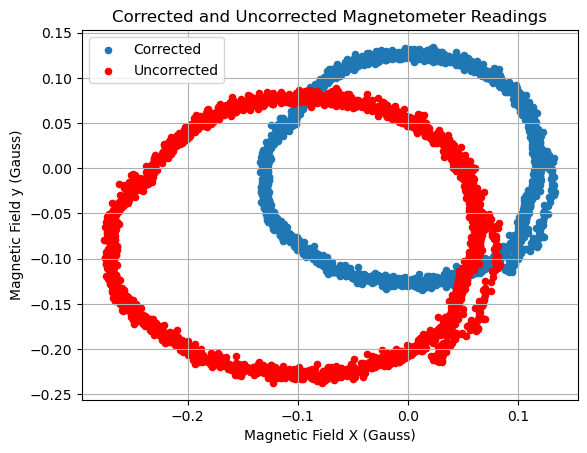

In [540]:
ax = imu_c.plot(x ='corrected_x', y ='corrected_y', kind = "scatter")
non_corrected = imu_c.plot(ax = ax, x ='MagField.magnetic_field.x', y ='MagField.magnetic_field.y', kind = "scatter", color = "red")
ax.set_xlabel("Magnetic Field X (Gauss)")
ax.set_ylabel("Magnetic Field y (Gauss)")
ax.set_title("Corrected and Uncorrected Magnetometer Readings")
ax.legend(['Corrected', 'Uncorrected'])
ax.grid()


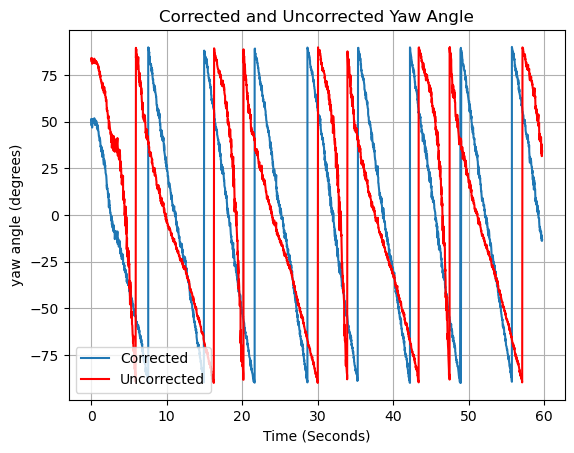

In [541]:
imu_c['yaw_correct'] = np.arctan((-1)*imu_c['corrected_y'] / imu_c['corrected_x'])
imu_c['yaw_correct'] = imu_c['yaw_correct'] * (180/ math.pi)
imu_c['yaw'] = np.arctan((-1)*imu_c['MagField.magnetic_field.y'] / imu_c['MagField.magnetic_field.x'])
imu_c['yaw'] = imu_c['yaw'] * (180 / math.pi)

ax = imu_c.plot(x ='Time', y ='yaw_correct', kind = "line")
non_corrected = imu_c.plot(ax = ax, x ='Time', y ='yaw', kind = "line", color = "red")
ax.set_xlabel("Time (Seconds)")
ax.set_ylabel("yaw angle (degrees)")
ax.set_title("Corrected and Uncorrected Yaw Angle")
ax.legend(['Corrected', 'Uncorrected'])
ax.grid()






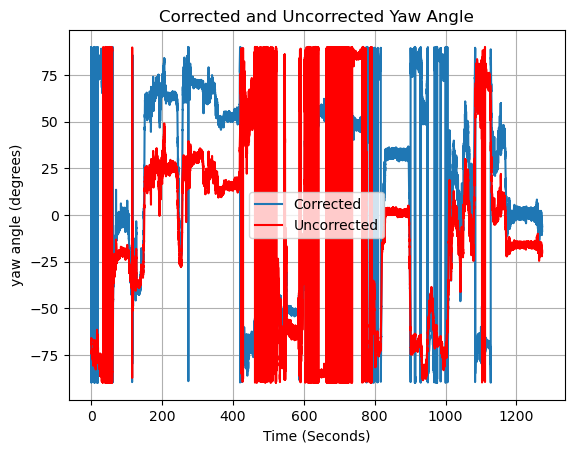

In [542]:
imu_bt['yaw_correct'] = np.arctan((-1)*imu_bt['corrected_y'] / imu_bt['corrected_x'])
imu_bt['yaw_correct'] = imu_bt['yaw_correct'] * (180/ math.pi)
imu_bt['yaw1'] = np.arctan((-1)*imu_bt['MagField.magnetic_field.y'] / imu_bt['MagField.magnetic_field.x'])
imu_bt['yaw1'] = imu_bt['yaw1'] * (180 / math.pi)



ax1 = imu_bt.plot(x ='Time', y ='yaw_correct', kind = "line")
non_corrected = imu_bt.plot(ax = ax1, x ='Time', y ='yaw1', kind = "line", color = "red")
ax1.set_xlabel("Time (Seconds)")
ax1.set_ylabel("yaw angle (degrees)")
ax1.set_title("Corrected and Uncorrected Yaw Angle")
ax1.legend(['Corrected', 'Uncorrected'])
ax1.grid()

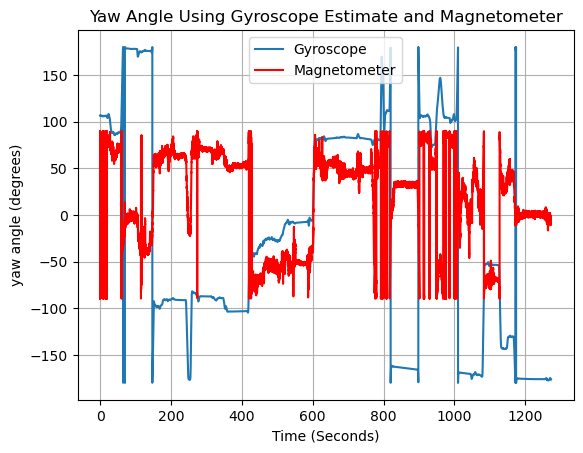

In [543]:
from scipy import integrate
import seaborn as sns
from scipy import stats

def wrapToPi(x):
    xwrap = np.remainder(x, 2 * np.pi)
    mask = np.abs(xwrap) > np.pi
    xwrap[mask] -= 2 * np.pi * np.sign(xwrap[mask])
    mask1 = x < 0
    mask2 = np.remainder(x, np.pi) == 0
    mask3 = np.remainder(x, 2 * np.pi) != 0
    xwrap[mask1 & mask2 & mask3] -= 2 * np.pi
    return xwrap

imu_bt['integral_x'] = integrate.cumtrapz(imu_bt['IMU.angular_velocity.x'], imu_bt['Time'], initial = 0)
imu_bt['integral_y'] = integrate.cumtrapz(imu_bt['IMU.angular_velocity.y'], imu_bt['Time'], initial = 0)
imu_bt['integral_z'] = integrate.cumtrapz(imu_bt['IMU.angular_velocity.z'], imu_bt['Time'], initial = 0)

imu_bt['integral_x'] = wrapToPi(imu_bt['integral_x']) * (180 / math.pi)
imu_bt['integral_y'] = wrapToPi(imu_bt['integral_y']) * (180 / math.pi)
imu_bt['integral_z'] = wrapToPi(imu_bt['integral_z'] + 360) * (180 / math.pi)

#imu_bt['integral_z'] = imu_bt['integral_z'] # * (180 / math.pi)

ax = imu_bt.plot(x ='Time', y ='integral_z', kind = "line")
imu_bt.plot(ax = ax, x ='Time', y ='yaw_correct', kind = "line", color = "red")
ax.set_xlabel("Time (Seconds)")
ax.set_ylabel("yaw angle (degrees)")
ax.set_title("Yaw Angle Using Gyroscope Estimate and Magnetometer")
ax.legend(['Gyroscope', 'Magnetometer'])
ax.grid()



In [544]:
import numpy as np
from scipy.signal import filtfilt, butter
from quaternion import quaternion, from_rotation_vector, rotate_vectors


def estimate_orientation(a, w, t, alpha=0.9, g_ref=(0., 0., 1.), theta_min=1e-4, highpass=.01, lowpass=.05):
    N = len(t)
    dt = np.diff(t)
    g_ref = np.array(g_ref)

    # get high-passed angular velocity
    w = filtfilt(*butter(5, highpass, btype='high'), w, axis=0, padlen= len(w) - 1)

    # get low-passed linear acceleration
    a = filtfilt(*butter(5, lowpass, btype='low'), a, axis=0, padlen= len(a) -1)


    return w,a


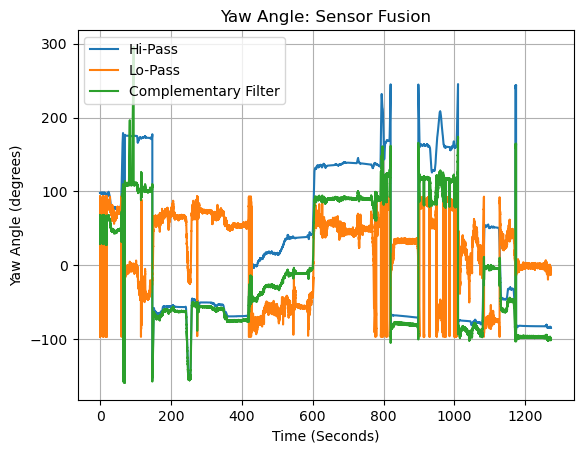

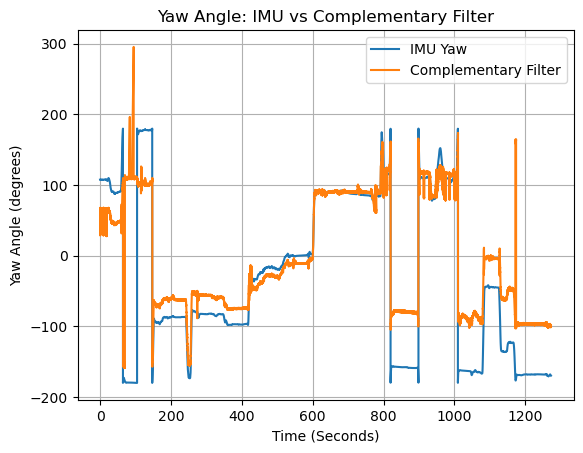

In [545]:
#magnetometer
mag = [imu_bt['roll'], imu_bt['pitch'], imu_bt['yaw_correct']]
integ = [imu_bt['integral_x'],imu_bt['integral_y'],imu_bt['integral_z']]
t = imu_bt['Time']

x,z = estimate_orientation(mag, integ ,t,alpha=0.9, g_ref=(0., 0., 1.), theta_min=0.1, highpass=0.001, lowpass=0.9)
imu_bt['hi-pass'] =  -x[2]
imu_bt['lo-pass'] =  z[2]
alpha = 0.2
imu_bt['cf'] = (alpha * (imu_bt['lo-pass'] + imu_bt['integral_z'] * imu_bt['Time'].diff()) + (1 - alpha) * imu_bt['hi-pass']) - 30
#imu_bt['yaw'] = (-1) * imu_bt['yaw']



ax = imu_bt.plot(x ='Time', y ='hi-pass', kind = "line")
imu_bt.plot(ax = ax, x ='Time', y ='lo-pass', kind = "line")
imu_bt.plot(ax = ax, x ='Time', y ='cf', kind = "line")
ax.set_xlabel("Time (Seconds)")
ax.set_ylabel("Yaw Angle (degrees)")
ax.set_title("Yaw Angle: Sensor Fusion")
ax.legend(['Hi-Pass', 'Lo-Pass','Complementary Filter'])
ax.grid()

ax = imu_bt.plot( x ='Time', y ='yaw', kind = "line")
imu_bt.plot(ax = ax, x ='Time', y ='cf', kind = "line")
ax.set_xlabel("Time (Seconds)")
ax.set_ylabel("Yaw Angle (degrees)")
ax.set_title("Yaw Angle: IMU vs Complementary Filter")
ax.legend(['IMU Yaw', 'Complementary Filter'])
ax.grid()




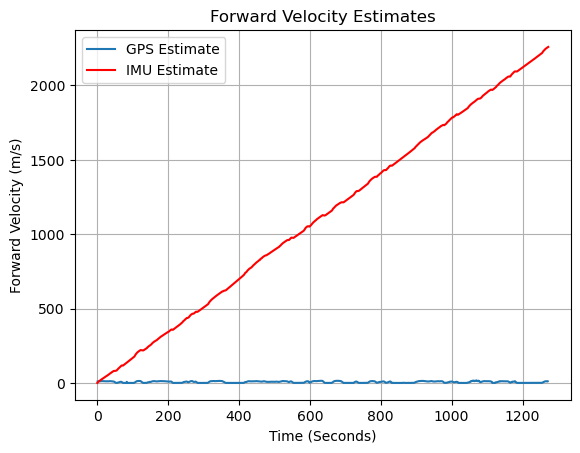

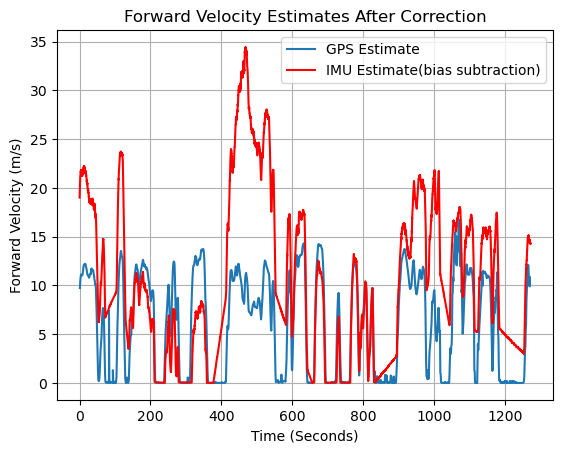

In [546]:
imu_bt['est_velocity_x'] = integrate.cumtrapz(imu_bt['IMU.linear_acceleration.x'], imu_bt['Time'], initial = 0)

gps_bt['Time'] = gps_bt['Time'] - gps_bt['Time'].min()
# gps_bt['UTM_easting'] = gps_bt['UTM_easting'] - gps_bt['UTM_easting'].min()
# gps_bt['UTM_northing'] = gps_bt['UTM_northing'] - gps_bt['UTM_northing'].min()

gps_bt['deriv_northing'] = np.gradient(gps_bt['UTM_northing'],1) / gps_bt['Time'].diff()
gps_bt['deriv_easting'] = np.gradient(gps_bt['UTM_easting'],1) / gps_bt['Time'].diff()

gps_bt['deriv_speed_mag'] = np.sqrt((gps_bt['deriv_northing']**2) + (gps_bt['deriv_easting']**2))
gps_bt  = gps_bt.drop(gps_bt[gps_bt.deriv_speed_mag > 1000].index)

#gps_bt.to_csv("data/gps1.csv", index=False)


ax = gps_bt.plot(x ='Time', y ='deriv_speed_mag', kind = "line")
imu_bt.plot(ax = ax, x ='Time', y ='est_velocity_x', kind = "line", color = "red")
ax.set_xlabel("Time (Seconds)")
ax.set_ylabel("Forward Velocity (m/s)")
ax.set_title("Forward Velocity Estimates")
ax.legend(['GPS Estimate', 'IMU Estimate'])
ax.grid()

#imu_bt['bias'] = imu_bt['est_velocity_x'] - imu_bt['est_velocity_x'].mean()
slope, intercept, r_value, p_value, std_err = stats.linregress(imu_bt['Time'],imu_bt['est_velocity_x'])
imu_bt['bias'] = (imu_bt['est_velocity_x'] - (slope * imu_bt['Time'] + intercept)) + 10
imu_bt = imu_bt.drop(imu_bt[imu_bt.bias < 0].index)

#imu_bt['bias'] = imu_bt[imu_bt['bias']]
#print(slope)

ax = gps_bt.plot(x ='Time', y ='deriv_speed_mag', kind = "line")
imu_bt.plot(ax = ax, x ='Time', y ='bias', kind = "line", color = "red")
ax.set_xlabel("Time (Seconds)")
ax.set_ylabel("Forward Velocity (m/s)")
ax.set_title("Forward Velocity Estimates After Correction")
ax.legend(['GPS Estimate', 'IMU Estimate(bias subtraction)'])
ax.grid()




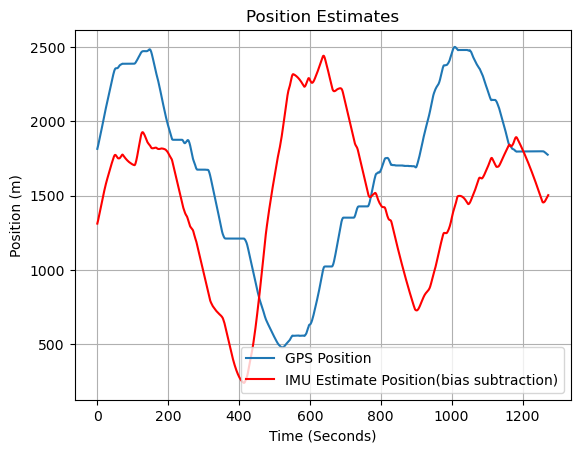

In [547]:
gps_bt['UTM_easting'] = gps_bt['UTM_easting'] - gps_bt['UTM_easting'].min()
gps_bt['UTM_northing'] = gps_bt['UTM_northing'] - gps_bt['UTM_northing'].min()
gps_bt['pos_mag'] = np.sqrt((gps_bt['UTM_northing']**2) + (gps_bt['UTM_easting']**2))

imu_bt['est_disp'] = integrate.cumtrapz(imu_bt['bias'], imu_bt['Time'], initial = 0)

slope, intercept, r_value, p_value, std_err = stats.linregress(imu_bt['Time'],imu_bt['est_disp'])
imu_bt['bias_disp'] =  (imu_bt['est_disp'] - (slope * imu_bt['Time'] + intercept)) + 1500


ax = gps_bt.plot(x ='Time', y ='pos_mag', kind = "line")
imu_bt.plot(ax = ax, x ='Time', y ='bias_disp', kind = "line", color = "red")
ax.set_xlabel("Time (Seconds)")
ax.set_ylabel("Position (m)")
ax.set_title("Position Estimates")
ax.legend(['GPS Position', 'IMU Estimate Position(bias subtraction)'])
ax.grid()

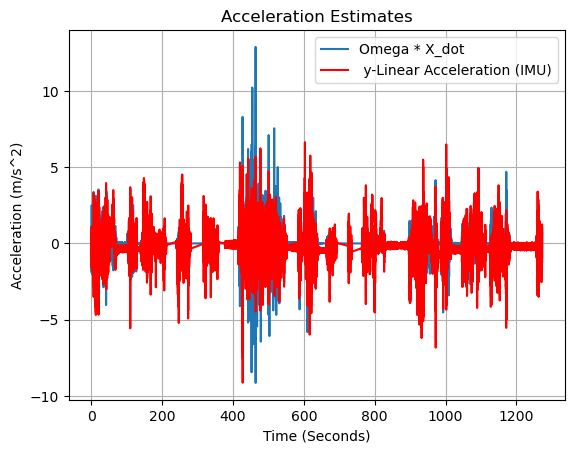

In [548]:
imu_bt['y_accel'] = imu_bt['bias'] * imu_bt['IMU.angular_velocity.x']

ax = imu_bt.plot(x ='Time', y ='y_accel', kind = "line")
imu_bt.plot(ax = ax, x ='Time', y ='IMU.linear_acceleration.y', kind = "line", color = "red")
ax.set_xlabel("Time (Seconds)")
ax.set_ylabel("Acceleration (m/s^2)")
ax.set_title("Acceleration Estimates")
ax.legend(['Omega * X_dot', ' y-Angular Acceleration (IMU)'])
ax.grid()

905.7859966298565 1572.9086102917208
-0.12601684980563732 -0.22606320969498483


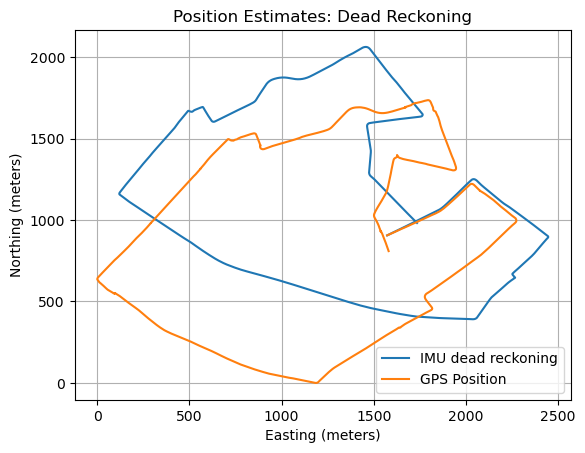

In [558]:
rot = 45
imu_bt['v_n'] = imu_bt['bias'] * np.sin((imu_bt['integral_z'] + rot) * (math.pi / 180)) 
imu_bt['v_e'] = -imu_bt['bias'] * np.cos((imu_bt['integral_z'] + rot) * (math.pi / 180))
imu_bt['x_n'] = ((integrate.cumtrapz(imu_bt['v_n'], imu_bt['Time'], initial = 0)) * 0.55) + 905.7871500734511 
imu_bt['x_e'] = ((integrate.cumtrapz(imu_bt['v_e'], imu_bt['Time'], initial = 0)) * 0.55) + 1572.9048335544328

o_n = gps_bt.iloc[0]['UTM_northing']
o_e = gps_bt.iloc[0]['UTM_easting']

t1 = o_n - imu_bt.iloc[1]['x_n']
t2 = o_e - imu_bt.iloc[1]['x_e']

ax = imu_bt.plot(x ='x_e', y ='x_n', kind = "line")
gps_bt.plot(ax=ax, x = 'UTM_easting', y ='UTM_northing', kind = "line")
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
ax.set_title("Position Estimates: Dead Reckoning")
ax.legend(['IMU dead reckoning', 'GPS Position'])
ax.grid()

print(o_n, o_e)
print(t1,t2)

In [551]:
imu_bt['deriv_w'] = np.gradient(imu_bt['IMU.angular_velocity.x'],1) / imu_bt['Time'].diff()

imu_bt['x_c'] = (imu_bt['IMU.linear_acceleration.y'] - imu_bt['y_accel']) / imu_bt['deriv_w']
imu_bt.drop([40920], axis=0, inplace=True)

# print(imu_bt['x_c'])
print(imu_bt.iloc[1: ]['x_c'].mean())



2.380585722884795
